# Data Dive Week 5: Regression in Python

Note that this notebook borrows heavily from the [online resources](https://github.com/cs109/2015lab4) for [CS109 at Harvard University](http://cs109.github.io/2015/pages/videos.html). 

***
This week we take a look at some basic statistical concepts, with a particular focus on regression models. As we covered in the [lecture portion]() of this week's class, linear regression is used to model and predict continuous outcomes. Time permitting, we'll also discuss logistic regression, which is used to model binary outcomes.

***

Though the DataCamp course covered for homework used the `numpy` package for linear regression, we'll also touch upon `statsmodels` and `scikit-learn` in today's exercise.
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset $X$ and $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $X_i$ without a $Y$ value.  </li>
  <li> Model the <b>strength of the relationship</b> between each dependent variable $X_i$ and $Y$</li>
    <ul>
      <li> Sometimes not all $X_i$ will have a relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to determine $Y$ </li>
    </ul>
</ul>
</div>

### A brief recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is linearly related to the dependent variable $Y$.  

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. This is the simplest form of linear regression (one variable), we'll call this the simple model. 

* $\beta_0$ is the intercept of the linear model

* Multiple linear regression is when you have more than one independent variable
    * $X_1$, $X_2$, $X_3$, $\ldots$

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 



***
# StreetEasy Rentals Data Set

Data from this week's exercise comes from [StreetEasy](www.streeteasy.com), an online platform for real estate listings in New York City. The sample provided covers 5,000 listings for homes for rent in Manhattan, Brooklyn, and Queens in June 2016 and provides several features of interest in modeling rents, including neighborhood, subway access, building amenities, 


Note that this data is provided for instructional purposes only and is not intended to be representative of all listings on StreetEasy or all homes for rent in New York City. Any analysis conducted as part of this exercise does not reflect the opinion or endorsement of StreetEasy or any of its affiliates.  


In [2]:
se_df = pd.read_csv('https://grantmlong.com/data/streeteasy_rents_june2016.csv')


In [3]:
se_df.head()

,﻿rental_id,building_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood,submarket,borough
0,1545,44518357,2550,0.0,1,480,9,2.0,17,1,1,0,0,1,1,0,1,Upper East Side,All Upper East Side,Manhattan
1,2472,94441623,11500,2.0,2,2000,4,1.0,96,0,0,0,0,0,0,0,0,Greenwich Village,All Downtown,Manhattan
2,10234,87632265,3000,3.0,1,1000,4,1.0,106,0,0,0,0,0,0,0,0,Astoria,Northwest Queens,Queens
3,2919,76909719,4500,1.0,1,916,2,51.0,29,0,1,0,1,1,1,0,0,Midtown,All Midtown,Manhattan
4,2790,92953520,4795,1.0,1,975,3,8.0,31,0,0,0,1,1,1,0,1,Greenwich Village,All Downtown,Manhattan


# Data Exploration

### Summarize and Plot a Histogram for the Target Variable

Is there anything surprising or interesting about this data?

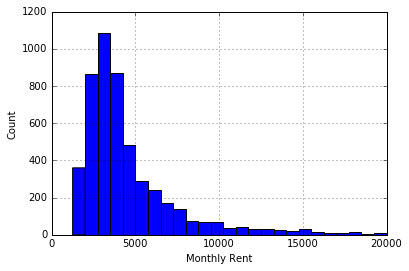

In [4]:
_ = se_df.rent.hist(bins=25)
_ = plt.xlabel('Monthly Rent')
_ = plt.ylabel('Count')

In [5]:
se_df.describe()

,﻿rental_id,building_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym
count,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,5526.909400,5.122007e+07,4536.920800,1.395700,1.321600,920.101400,5.079200,10.190200,52.093200,0.429600,0.12860,0.133800,0.228000,0.240000,0.155600,0.045600,0.143800
std,3263.692417,2.802283e+07,2929.838953,0.961018,0.565542,440.150464,5.268897,10.565361,40.224501,0.495069,0.33479,0.340471,0.419585,0.427126,0.362512,0.208637,0.350922
min,1.000000,7.107000e+03,1250.000000,0.000000,0.000000,250.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2699.750000,2.699811e+07,2750.000000,1.000000,1.000000,633.000000,2.000000,3.000000,12.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5456.500000,5.069894e+07,3600.000000,1.000000,1.000000,800.000000,4.000000,6.000000,44.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8306.000000,7.572064e+07,5200.000000,2.000000,2.000000,1094.000000,6.000000,14.000000,89.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11349.000000,9.998721e+07,20000.000000,5.000000,5.000000,4800.000000,51.000000,83.000000,180.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Exploration
##### If we wanted to try to create a model to price any given apartment, what variables might be the most important?
* How many variables are at our disposal?
* Which are binary? Categorical? Continuous? 
* Which variable make most sense to use from an intuitive standpoint?
* Identify which variable has the highest correlation with 


In [6]:
print(list(se_df))
print()

se_df.describe()

['\xef\xbb\xbfrental_id', 'building_id', 'rent', 'bedrooms', 'bathrooms', 'size_sqft', 'min_to_subway', 'floor', 'building_age_yrs', 'no_fee', 'has_roofdeck', 'has_washer_dryer', 'has_doorman', 'has_elevator', 'has_dishwasher', 'has_patio', 'has_gym', 'neighborhood', 'submarket', 'borough']
()


,﻿rental_id,building_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym
count,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,5526.909400,5.122007e+07,4536.920800,1.395700,1.321600,920.101400,5.079200,10.190200,52.093200,0.429600,0.12860,0.133800,0.228000,0.240000,0.155600,0.045600,0.143800
std,3263.692417,2.802283e+07,2929.838953,0.961018,0.565542,440.150464,5.268897,10.565361,40.224501,0.495069,0.33479,0.340471,0.419585,0.427126,0.362512,0.208637,0.350922
min,1.000000,7.107000e+03,1250.000000,0.000000,0.000000,250.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2699.750000,2.699811e+07,2750.000000,1.000000,1.000000,633.000000,2.000000,3.000000,12.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5456.500000,5.069894e+07,3600.000000,1.000000,1.000000,800.000000,4.000000,6.000000,44.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8306.000000,7.572064e+07,5200.000000,2.000000,2.000000,1094.000000,6.000000,14.000000,89.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11349.000000,9.998721e+07,20000.000000,5.000000,5.000000,4800.000000,51.000000,83.000000,180.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
se_df.corr()['rent'].sort_values(ascending=False)[1:]

size_sqft           0.808784
bathrooms           0.733644
bedrooms            0.531200
floor               0.272351
has_elevator        0.120822
has_doorman         0.099106
has_dishwasher      0.096631
has_washer_dryer    0.096136
has_gym             0.093737
has_roofdeck        0.081286
has_patio           0.058260
min_to_subway       0.003652
building_id        -0.001235
no_fee             -0.091769
building_age_yrs   -0.122302
﻿rental_id         -0.142801
Name: rent, dtype: float64

### Scatterplots
* Create a scatterplot of `size_sqft`, `bathrooms`, and `floor`.  
* Describe the relationship you see? Is it positive or negative? Linear? Non-linear? 

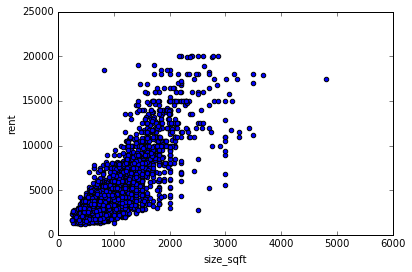

In [8]:
_ = se_df.plot.scatter('size_sqft', 'rent')

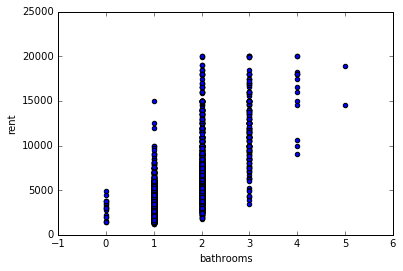

In [9]:
_ = se_df.plot.scatter('bathrooms', 'rent')

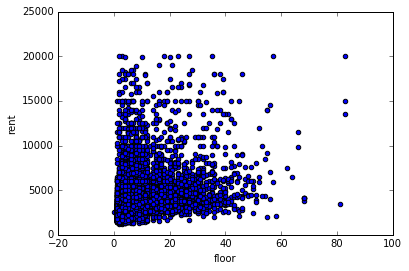

In [10]:
_ = se_df.plot.scatter('floor', 'rent')

# Modeling
### Single Variable Linear Regression with `size_sqft`
* Use `numpy` to fit a simple linear regression
  - Calculate the slope and intercept using the `polyfit` function
  - Print the slope and intercept. How would you interpret these two numbers?
  - Based on this data, how much would expect a 700 square foot apartment to cost?
  

In [11]:
beta, alpha = np.polyfit(se_df.size_sqft, se_df.rent, 1)
print('beta: %0.3f, alpha: %0.1f.' % (beta, alpha))
print()

beta: 5.384, alpha: -416.6.
()


In [12]:
print('Based on this analysis a 700 square foot apartment would rent for $%0.2f' 
      % (beta * 700 + alpha))

Based on this analysis a 700 square foot apartment would rent for $3351.98


##### Visualize the relationship. 
  - Plot the fitted line along with the scatter plot.
  - Is this line a good fit?

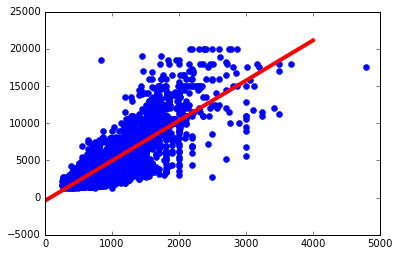

In [13]:
_ = plt.plot(se_df.size_sqft, se_df.rent, color='blue', marker='.', markersize=12, linestyle='none')
_ = plt.plot([0, 4000], [alpha, alpha + beta * 4000],  color='red', linewidth=4)
_ = plt.title('')


##### Calculate the predicted rent and residual for each observation. 
  - Create columns in the `se_df` dataframe for `rent_predicted` and `rent_residual` 
  - Does this appear to fall in line with the assumptions we've described? 

In [14]:
se_df['rent_predicted'] = se_df['rent'] * beta + alpha
se_df['rent_residual'] = se_df['rent_predicted'] - se_df['rent']


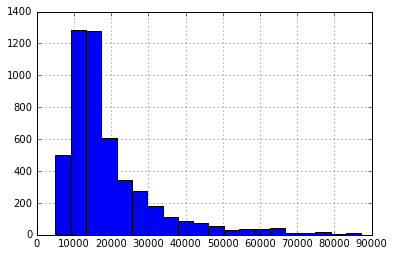

In [15]:
se_df['rent_residual'].hist(bins=20)

### Using `statsmodels` for Single Variable Linear Regression
* Use `statsmodels` to fit a simple linear regression with `size_sqft`.
  - Output the regression results. 
  - Describe how this output compares to our $\alpha$ and $\beta$ from `numpy`.

In [16]:
# Add a constant to our existing dataframe for modeling purposes
se_df = sm.add_constant(se_df)

est = sm.OLS(se_df['rent'], 
             se_df[['const', 'size_sqft']]
            ).fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     9453.
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        00:37:11   Log-Likelihood:                -44353.
No. Observations:                5000   AIC:                         8.871e+04
Df Residuals:                    4998   BIC:                         8.872e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -416.5609     56.478     -7.376      0.0

### Using `statsmodels` for Multiple Linear Regression
* Still using `statsmodels`, add some variables to our exisiting regression. Can you get a better prediction?
  - Add a one or two variables at a time. What happens to our $R^2$?
  - Which variables are most significant? How does this change as we add more predictors?
  - With regression with many predictors, create a histogram of the residuals. How does this compare to the single variable case?
    * *Note: use can access the residuals using the* `est.resid` *attribute of the regression results.*

In [17]:
est = sm.OLS(se_df['rent'], 
             se_df[['const', 'size_sqft', 'bathrooms', 'floor', 'has_doorman']]
            ).fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     3151.
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        00:37:11   Log-Likelihood:                -43859.
No. Observations:                5000   AIC:                         8.773e+04
Df Residuals:                    4995   BIC:                         8.776e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const       -1362.8677     59.283    -22.989      

In [18]:
est = sm.OLS(se_df['rent'], 
             se_df.drop(['neighborhood', 'submarket', 'borough', 'rent', 'rent_predicted', 'rent_residual'], axis=1)
            ).fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     858.1
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        00:37:11   Log-Likelihood:                -43700.
No. Observations:                5000   AIC:                         8.743e+04
Df Residuals:                    4983   BIC:                         8.754e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const             -777.1793    100.937  

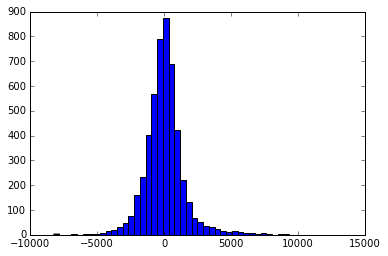

In [19]:
_ = plt.hist(est.resid, bins=50)

### Using `sklearn` for Multiple Linear Regression
`sklearn` is among the most popular packages for machine learning, and it's one we'll be using throughout the rest of the semester. It's syntax and functionality is a little different, but it gives us a little more flexibility around accessing and using the output, and also plays nice with modeling options beyond linear regression. 


In [20]:
# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### What can you do with a LinearRegression object? 

In [21]:
# Look inside linear regression object
# LinearRegression.<tab>

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?


In [22]:
# Look inside lm object
# lm.<tab>

Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

#### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [23]:
# Use sensible subset of predictors to fit linear regression model
dependent_vars = ['bedrooms', 'bathrooms', 'min_to_subway', 'floor', 
                  'building_age_yrs', 'no_fee', 'has_roofdeck', 
                  'has_washer_dryer', 'has_doorman', 'has_elevator', 
                  'has_dishwasher', 'has_patio', 'has_gym']

X = se_df[dependent_vars]

lm.fit(X, se_df.rent)

# notice fit_intercept=True and normalize=True
# How would you change the model to not fit an intercept term? 


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [24]:
print('Estimated intercept coefficient:', lm.intercept_)
print('Number of coefficients:', len(lm.coef_))

('Estimated intercept coefficient:', -515.50403608104898)
('Number of coefficients:', 13)


In [25]:
# The coefficients
pd.DataFrame(lm.coef_, index=dependent_vars,  columns = ['Est. Coefficient'])

,Est. Coefficient
bedrooms,417.730687
bathrooms,3171.816130
min_to_subway,-22.630204
floor,49.132507
building_age_yrs,-1.488370
no_fee,-344.120712
has_roofdeck,-4.475219
has_washer_dryer,191.475476
has_doorman,-41.004582
has_elevator,400.797299


#### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [26]:
# first five predicted prices
lm.predict(X)[0:5]

array([ 2629.06488344,  6479.31777692,  3710.34863476,  5994.05257186,
        3764.12600492])

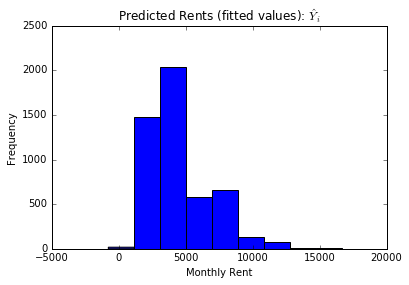

In [27]:
_ = plt.hist(lm.predict(X))
_ = plt.title('Predicted Rents (fitted values): $\hat{Y}_i$')
_ = plt.xlabel('Monthly Rent')
_ = plt.ylabel('Frequency')

Let's plot the true prices compared to the predicted prices to see they disagree, we saw this exactly befor but this is how you access the predicted values in using `sklearn`.

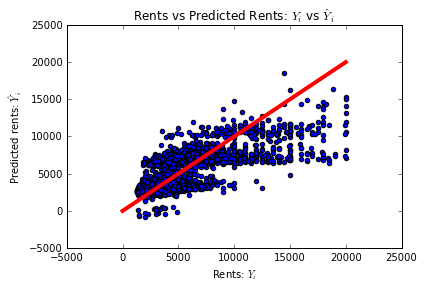

In [28]:
_ = plt.scatter(se_df['rent'], lm.predict(X))
_ = plt.xlabel("Rents: $Y_i$")
_ = plt.ylabel("Predicted rents: $\hat{Y}_i$")
_ = plt.title("Rents vs Predicted Rents: $Y_i$ vs $\hat{Y}_i$")
_ = plt.plot([0, 20000], [0, 20000], linewidth=4, color='red')

### Residual sum of squares

Let's calculate the residual sum of squares 

$$ S = \sum_{i=1}^N r_i = \sum_{i=1}^N (y_i - (\beta_0 + \beta_1 x_i))^2 $$

In [29]:
print('%0.2f' %  np.sum((se_df['rent'] - lm.predict(X)) ** 2))

17730479762.04


# Bonus Round: Feature Engineering

Our original data set featured information on borough, submarket, neighborhood - all different ways of slices up the city in *geographic* terms. 
* To what extent do you think models will return different results across different boroughs?
* How might you include some or all of these geographic areas in the model? 